<a href="https://colab.research.google.com/github/alexjochs/ECE_539_Penguins/blob/preprocess/PenguinsPreprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
# Alex
gdrive_data_filepath = r"/content/gdrive/MyDrive/'Penguin_counting'/data_peng_watch"
# Oscar
# gdrive_data_filepath = r'/content/drive/MyDrive/Colab\ Notebooks/539\ Project/data'

Mounted at /content/gdrive


In [40]:
import os
import pandas as pd
import json
import numpy as np
from tqdm import tqdm
from matplotlib import image
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
import scipy
from scipy.spatial import KDTree
import h5py
import time
from PIL import Image

In [4]:
VM_ROOT = r'/content'
cwd = None
def get_new_batch(target=None, load_all=False):
    assert target == None or load_all == False, f"can't get specific folder: {target} and load all data"
    if not target:
        print("Specifiy target")
    tgz_name = target + '.tgz'
    folder_path = os.path.join(gdrive_data_filepath, tgz_name)
    !tar --gunzip --extract --verbose --file={folder_path} --directory {VM_ROOT}
    cwd = os.path.join(VM_ROOT, target)

def save_batch_to_drive(target=None, save_all=False):
    # take working files, save them back to Gdrive
    assert target == None or save_all == False, f"can't get specific folder: {target} and load all data"
    tgz_name = target + '_gt.tgz'
    folder_path = os.path.join(gdrive_data_filepath, tgz_name)
    !tar -c -f -z -v {tgz_name} {folder_path}

In [5]:
annotations_path = VM_ROOT + r'/CompleteAnnotations_2016-07-11'

def run_all():
    json_filepath_list = get_json_files_from_folder()
    for filepath in json_filepath_list:
        df = run(filepath_=filepath)
        save_df_as_json(df)

def run(filepath_=None, target=None):
    assert filepath_ is not None, "at this time run() method needs a full filepath"
    data_group_name = filepath_[-10:-5]
    df = load_json_as_df(filepath_)
    df.loc[df.xy.isnull(), 'xy'] = [[]]
    # have to check if inner list has na values as well :/
    df_xy_ = to_1D(df['xy'])
    if df_xy_.isna().sum() > 0:
        df_xy_na_mask = df_xy_.isna()
        df.loc[df_xy_na_mask, 'xy'] = [[]]
    return df

def save_df_as_json(df):
    data_group_filename = df['imName'].iloc[0][:5] + '.json'
    try:
        os.mkdir('/content/annotations')
    except FileExistsError as e:
        print('looks like local annotations folder already exists!')
    print(data_group_filename)
    with open(os.path.join('/content/annotations', data_group_filename), 'w') as json_file:
        json.dump(json.loads(df.to_json(orient='records')), json_file)

def get_json_files_from_folder():
    json_filepath_list = []
    for filename in os.listdir(annotations_path):
        f = os.path.join(annotations_path, filename)
        if os.path.isfile(f):
            file_extension = os.path.splitext(f)[1]
        if file_extension == '.json':
            json_filepath_list.append(f)
    return json_filepath_list

def load_json_as_df(filepath):
    with open(filepath,'r') as json_file:
        json_data = json.loads(json_file.read())
    return pd.json_normalize(json_data, record_path =['dots'])

def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

In [35]:
# dots: 2d list of xy dots from users
# return longest (ie most penguins clicked) 1d list
def get_longest_dot_list(dots):
    if len(dots) == 0:
        return []
    if not type(dots[0]) == type([]):
        return []
    idx = 0
    if len(dots) > 1:
        for i, x in enumerate(dots):
            if len(x) > len(dots[idx]):
                idx = i
    return dots[idx]

# One hot encoding of user clicks
def make_sparse_mat(img_shape, dots):
    mat = np.zeros((img_shape[0], img_shape[1]))
    for dot in dots:
        mat[dot[1], dot[0]] = 1

    return mat

def gaussian_filter_density(gt):
    #Generates a density map using Gaussian filter transformation
    
    density = np.zeros(gt.shape, dtype=np.float32)
    
    gt_count = np.count_nonzero(gt)
    
    if gt_count == 0:
        return density

    # FInd out the K nearest neighbours using a KDTree
    
    pts = np.array(list(zip(np.nonzero(gt)[1].ravel(), np.nonzero(gt)[0].ravel())))
    leafsize = 2048
    
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    
    # query kdtree
    distances, locations = tree.query(pts, k=4)

        
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        
        #Convolve with the gaussian filter
        
        # density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
        input_ = np.fft.fft2(pt2d)
        result = scipy.ndimage.fourier_gaussian(input_, sigma)
        density = np.add(density, np.fft.ifft2(result).real, casting="unsafe")
    
    return density

In [7]:
get_new_batch(target=r'CompleteAnnotations_2016-07-11')

CompleteAnnotations_2016-07-11/BAILa.json
CompleteAnnotations_2016-07-11/BAILa.mat
CompleteAnnotations_2016-07-11/DAMOa.json
CompleteAnnotations_2016-07-11/DAMOa.mat
CompleteAnnotations_2016-07-11/GEORa.json
CompleteAnnotations_2016-07-11/GEORa.mat
CompleteAnnotations_2016-07-11/HALFb.json
CompleteAnnotations_2016-07-11/HALFb.mat
CompleteAnnotations_2016-07-11/HALFc.json
CompleteAnnotations_2016-07-11/HALFc.mat
CompleteAnnotations_2016-07-11/LOCKb.json
CompleteAnnotations_2016-07-11/LOCKb.mat
CompleteAnnotations_2016-07-11/MAIVb.json
CompleteAnnotations_2016-07-11/MAIVb.mat
CompleteAnnotations_2016-07-11/MAIVc.json
CompleteAnnotations_2016-07-11/MAIVc.mat
CompleteAnnotations_2016-07-11/NEKOa.json
CompleteAnnotations_2016-07-11/NEKOa.mat
CompleteAnnotations_2016-07-11/NEKOb.json
CompleteAnnotations_2016-07-11/NEKOb.mat
CompleteAnnotations_2016-07-11/NEKOc.json
CompleteAnnotations_2016-07-11/NEKOc.mat
CompleteAnnotations_2016-07-11/PETEc.json
CompleteAnnotations_2016-07-11/PETEc.mat
Comp

In [8]:
# TODO BAILa will be from looping over master list
get_new_batch('BAILa')  # TODO
df = run(filepath_=r'/content/CompleteAnnotations_2016-07-11/BAILa.json')
df.head()

Streaming output truncated to the last 5000 lines.
BAILa/BAILa2014a_000215.JPG
BAILa/BAILa2014a_000216.JPG
BAILa/BAILa2014a_000217.JPG
BAILa/BAILa2014a_000218.JPG
BAILa/BAILa2014a_000219.JPG
BAILa/BAILa2014a_000220.JPG
BAILa/BAILa2014a_000221.JPG
BAILa/BAILa2014a_000222.JPG
BAILa/BAILa2014a_000223.JPG
BAILa/BAILa2014a_000224.JPG
BAILa/BAILa2014a_000225.JPG
BAILa/BAILa2014a_000226.JPG
BAILa/BAILa2014a_000227.JPG
BAILa/BAILa2014a_000228.JPG
BAILa/BAILa2014a_000229.JPG
BAILa/BAILa2014a_000230.JPG
BAILa/BAILa2014a_000231.JPG
BAILa/BAILa2014a_000232.JPG
BAILa/BAILa2014a_000233.JPG
BAILa/BAILa2014a_000234.JPG
BAILa/BAILa2014a_000235.JPG
BAILa/BAILa2014a_000236.JPG
BAILa/BAILa2014a_000237.JPG
BAILa/BAILa2014a_000238.JPG
BAILa/BAILa2014a_000239.JPG
BAILa/BAILa2014a_000240.JPG
BAILa/BAILa2014a_000241.JPG
BAILa/BAILa2014a_000242.JPG
BAILa/BAILa2014a_000243.JPG
BAILa/BAILa2014a_000244.JPG
BAILa/BAILa2014a_000245.JPG
BAILa/BAILa2014a_000246.JPG
BAILa/BAILa2014a_000247.JPG
BAILa/BAILa2014a_000248.J

,imName,xy
0,BAILa2014a_000001,"[[[350, 1455], [849, 1327], [1129, 1042], [73,..."
1,BAILa2014a_000002,[]
2,BAILa2014a_000003,"[[[48, 293], [62, 293], [46, 319], [71, 314], ..."
3,BAILa2014a_000004,"[[[1340, 1140], [914, 1335], [192, 1162], [35,..."
4,BAILa2014a_000005,"[[[1022, 1309], [161, 1167], [23, 875], [530, ..."


In [36]:
os.chdir(VM_ROOT + '/BAILa') # TODO
for i, row in df.iterrows():
    img_name = row['imName']
    img_dots = row['xy']
    img = image.imread(os.path.join('/content/BAILa', row['imName']) + '.JPG') # TODO

    dots = get_longest_dot_list(img_dots)
    k = make_sparse_mat(img.shape, dots)
    start_time = time.time()
    k = gaussian_filter_density(k)
    print(f"--- {(time.time() - start_time)} seconds ---")

    break

    with h5py.File(img_name+'_gt.h5', 'w') as f:
        f['density'] = k

--- 35.34582877159119 seconds ---


some ideas to improve speed:  
- load all images into memory
- downsample images to input size
- - w/ fft, down to 4 sec!
- use mutiprocessing to speed up execution
- use fft instead of gaussian filter?
- - It works! down to 35 sec per image

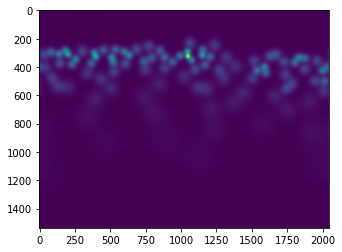

In [37]:
plt.imshow(k)

In [38]:
abs(k).sum()

97.00000000000003

In [39]:
print(k.shape)

(1536, 2048)


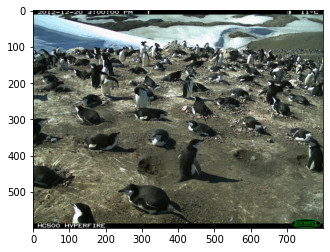

In [43]:

for i, row in df.iterrows():
    img = Image.open(os.path.join('/content/BAILa', row['imName']) + '.JPG')
    img = img.resize((800, 600), Image.ANTIALIAS)
    plt.imshow(img)
    break

In [44]:
# now to downsample the dots
original_img_dim = {'BAILa' : (2048, 1536)}
print(dots)

[[350, 1455], [849, 1327], [1129, 1042], [73, 1157], [476, 934], [898, 905], [1233, 841], [1579, 806], [1923, 863], [1982, 1071], [1909, 646], [1754, 703], [1665, 607], [1746, 555], [2015, 570], [1786, 518], [1950, 499], [1877, 416], [1741, 454], [1601, 442], [1508, 481], [1444, 580], [1373, 656], [1216, 693], [28, 830], [343, 745], [400, 624], [510, 551], [742, 615], [817, 730], [849, 518], [1122, 546], [1024, 469], [751, 420], [796, 336], [776, 255], [689, 277], [201, 540], [92, 477], [43, 403], [34, 312], [147, 374], [87, 297], [186, 285], [232, 383], [439, 487], [530, 435], [259, 346], [141, 310], [306, 290], [636, 319], [525, 369], [887, 408], [1049, 293], [854, 285], [946, 364], [742, 361], [513, 332], [1186, 555], [1103, 418], [1304, 481], [1387, 398], [1521, 359], [1629, 325], [1806, 369], [1272, 422], [1322, 334], [1172, 386], [609, 379], [370, 374], [456, 282], [1963, 357], [1877, 339], [1675, 312], [1592, 400], [1731, 364], [1240, 248], [1156, 280], [1066, 234], [1051, 325],

In [62]:
original_img_dim = {'BAILa' : (2048, 1536)}
def downsample_dots(dots, data_group):
    """convert xy coords of annotations down to 600x800 img space"""
    ds_dots = []
    original_dim = original_img_dim[data_group]
    x_scaler = 600.0 / float(original_dim[0])
    y_scaler = 800.0 / float(original_dim[1])
    for dot in dots:
        ds_dots.append([floor(dot[0] * y_scaler), floor(dot[1] * x_scaler)])
    return ds_dots

--- 4.2259063720703125 seconds ---


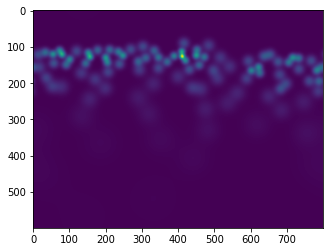

In [63]:
k_ds = make_sparse_mat((600, 800), ds_dots)
start_time = time.time()
k_ds = gaussian_filter_density(k_ds)
print(f"--- {(time.time() - start_time)} seconds ---")
plt.imshow(k_ds)

In [61]:
k_ds.sum()

96.99999999999999